In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from collections import OrderedDict

# Cell type predictions

In [ ]:
f_pred_dir = 'cell_type_classification/'
f_list = os.listdir(f_pred_dir)
f_list

In [3]:
ct_pred = {}
for f in f_list:
    k = f.split('__')[0]
    ct_pred[k] = pd.read_csv(os.path.join(f_pred_dir, f), sep='\t')
ct_pred

{'TXG_10xv11_1.FULL':                                     composite_sample_id  \
 0                    GGTCTAAACCAGCAAG-TXG_10xv11_1.FULL   
 1                    TAGGCCTCTAAGTCTC-TXG_10xv11_1.FULL   
 2                    TGCCTACTGCCATGTA-TXG_10xv11_1.FULL   
 3                    ATCAAGCACAATCGAA-TXG_10xv11_1.FULL   
 4                    ACTTATCACGCGCACT-TXG_10xv11_1.FULL   
 ...                                                 ...   
 9929                 TTGTATCTGACACAAA-TXG_10xv11_1.FULL   
 9930                 CATTACTTGGCTAGAG-TXG_10xv11_1.FULL   
 9931  CCTTCTTTGGCGGTTC_TACCAGTGAGCCCTAG-TXG_10xv11_1...   
 9932                 AGCCAATTGGAAGGCT-TXG_10xv11_1.FULL   
 9933                 TTTAAGCCTAATCTGC-TXG_10xv11_1.FULL   
 
                                 barcode          sample_id         cell_type  \
 0                      GGTCTAAACCAGCAAG  TXG_10xv11_1.FULL       CD4+ T cell   
 1                      TAGGCCTCTAAGTCTC  TXG_10xv11_1.FULL  Cytotoxic T cell   
 2            

In [4]:
ct_pred_dict = {}
ct_pred_dict['Libds'] = ct_pred.copy()

In [5]:
alias_dict = OrderedDict({
    "Broad_1": "BioRad ATAC 1",
    "Broad_2": "BioRad ATAC 2",
    "Stanford_1": "10x ATAC A1",
    "Stanford_2": "10x ATAC A2",
    "VIB_1": "10x ATAC B1",
    "VIB_2": "10x ATAC B2",
    "CNAG_1": "10x ATAC C1",
    "CNAG_2": "10x ATAC C2",
    "Broad_mito_1": "10x mtATAC 1",
    "Broad_mito_2": "10x mtATAC 2",
    "Sanger_1": "10x Multiome 1",
    "Sanger_2": "10x Multiome 2",
    "VIB_Hydrop_1": "Hydrop ATAC 1",
    "VIB_Hydrop_2": "Hydrop ATAC 2",
    "s3atac": "s3 ATAC",
    # "merged": "Merged"
})

In [6]:
ct_pred_alias = {}
for x in alias_dict.keys():
    ct_pred_alias[alias_dict[x]] = ct_pred.pop(x)

KeyError: 'Broad_1'

In [ ]:
ct_pred_alias = ct_pred_dict

### Fraction of cells passing thresholds

In [44]:
def calc_frac_cells_passing_threshold(ct_pred, order, step=0.1):
    # calculate fraction of cells passing thresholds
    step = 0.1
    tmp = []
    auc = {}
    threshold_dict = {}
    for k,x in {key: ct_pred[key] for key in order}.items():

        thrs = np.arange(0,1+step,step)
        tmpdf = pd.DataFrame([
            thrs,
            [ sum(x['cell_type_pred_score'] >= thr) for thr in thrs ],
        ]).T
        tmpdf.columns = ['Threshold', 'Score']

        tmpdf['Score'] = tmpdf['Score']/x.shape[0]
        auc[k] = np.trapz(tmpdf['Score'].to_numpy(), x=tmpdf['Threshold'].to_numpy() )
        #tmpdf['Sample'] = k
        tmpdf['Sample'] = f"{k} ({round(auc[k],3)})"
        threshold_dict[k] = round(auc[k],3)
        tmp.append(tmpdf)
        #break
    tp = pd.concat(tmp, ignore_index=True)
    return tp, threshold_dict


def plot_frac_cells_passing_threshold(tp, ax, title="", leg_size=8,
                                      x='Threshold', y='Score',
                                      hue='Sample',
                                      style='Sample',
                                      palette='tab20'
                                     ):
    #dashes=[(''),(2,1)] * int(tp['Sample'].unique().size/2) + ['']
    n = tp['Sample'].unique().size
    if((n % 2) == 0):
        dashes=[(''),(2,1)] * int(n/2)
    else:
        dashes=[(''),(2,1)] * int(n/2) + ['']

    sns.lineplot(x=x, y=y,
                 hue=hue,
                 style=style,
                 dashes=dashes,
                 markers=True,
                 ax=ax,
                 palette=palette,
                 #size=0.8, #alpha=0.8,
                 lw=1,
                 data=tp)
    ax.set_xlabel('Threshold on prediction score')
    ax.set_ylabel('Fraction of cells passing threshold')
    #plt.legend(bbox_to_anchor=(1.025, 1), loc=2, borderaxespad=0., fontsize=8)
    ax.grid(color='0.9')
    ax.legend(loc=3, fontsize=leg_size)
    ax.set_title(title)

In [45]:
# reorder legends function
import numpy as np
#  Returns tuple of handles, labels for axis ax, after reordering them to conform to the label order `order`, and if unique is True, after removing entries with duplicate labels.
def reorderLegend(ax=None,order=None,unique=False):
    if ax is None: ax=plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0])) # sort both labels and handles by labels
    if order is not None: # Sort according to a given list (not necessarily complete)
        keys=dict(zip(order,range(len(order))))
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t,keys=keys: keys.get(t[0],np.inf)))
    if unique:  labels, handles= zip(*unique_everseen(zip(labels,handles), key = labels)) # Keep only the first of each handle
    ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) # i modified this line 

    return(handles, labels)


def unique_everseen(seq, key=None):
    seen = set()
    seen_add = seen.add
    return [x for x,k in zip(seq,key) if not (k in seen or seen_add(k))]

#source: https://stackoverflow.com/questions/22263807/how-is-order-of-items-in-matplotlib-legend-determined

In [46]:
order = [alias_dict[x] for x in alias_dict.keys()]

In [47]:
order = ct_pred_dict.keys()

In [48]:
ct_pred.keys()

dict_keys(['CNA_mtscatac_1.FULL', 'VIB_hydrop_21.FULL', 'BRO_mtscatac_2.FULL', 'SAN_10xmultiome_2.FULL', 'EPF_hydrop_3.FULL', 'STA_10xv11_2.FULL', 'OHS_s3atac_1.FULL', 'VIB_hydrop_22.FULL', 'CNA_ddseq_1.FULL', 'VIB_10xv1_1.FULL', 'CNA_10xv11_1.FULL', 'CNA_hydrop_3.FULL', 'VIB_hydrop_12.FULL', 'STA_10xv11_1.FULL', 'CNA_10xmultiome_1.FULL', 'CNA_10xv11_4.FULL', 'CNA_10xv2_2.FULL', 'VIB_hydrop_11.FULL', 'VIB_10xmultiome_1.FULL', 'HAR_ddseq_2.FULL', 'OHS_s3atac_2.FULL', 'VIB_10xmultiome_2.FULL', 'CNA_10xv2_1.FULL', 'EPF_hydrop_4.FULL', 'CNA_ddseq_2.FULL', 'VIB_10xv2_1.FULL', 'BRO_mtscatac_1.FULL', 'HAR_ddseq_1.FULL', 'CNA_mtscatac_2.FULL', 'CNA_10xv11_2.FULL', 'SAN_10xmultiome_1.FULL', 'CNA_10xv11_5.FULL', 'VIB_10xv2_2.FULL', 'BIO_ddseq_3.FULL', 'CNA_hydrop_2.FULL', 'CNA_10xv11_3.FULL', 'BIO_ddseq_4.FULL', 'CNA_hydrop_1.FULL', 'EPF_hydrop_1.FULL', 'CNA_10xmultiome_2.FULL', 'EPF_hydrop_2.FULL'])

In [49]:
tp, threshold_dict = calc_frac_cells_passing_threshold(ct_pred, order=ct_pred.keys(), step=0.1)

In [50]:
threshold_dict

{'CNA_mtscatac_1.FULL': 0.72,
 'VIB_hydrop_21.FULL': 0.618,
 'BRO_mtscatac_2.FULL': 0.821,
 'SAN_10xmultiome_2.FULL': 0.763,
 'EPF_hydrop_3.FULL': 0.576,
 'STA_10xv11_2.FULL': 0.779,
 'OHS_s3atac_1.FULL': 0.688,
 'VIB_hydrop_22.FULL': 0.595,
 'CNA_ddseq_1.FULL': 0.44,
 'VIB_10xv1_1.FULL': 0.864,
 'CNA_10xv11_1.FULL': 0.804,
 'CNA_hydrop_3.FULL': 0.506,
 'VIB_hydrop_12.FULL': 0.61,
 'STA_10xv11_1.FULL': 0.754,
 'CNA_10xmultiome_1.FULL': 0.774,
 'CNA_10xv11_4.FULL': 0.794,
 'CNA_10xv2_2.FULL': 0.773,
 'VIB_hydrop_11.FULL': 0.628,
 'VIB_10xmultiome_1.FULL': 0.748,
 'HAR_ddseq_2.FULL': 0.753,
 'OHS_s3atac_2.FULL': 0.638,
 'VIB_10xmultiome_2.FULL': 0.759,
 'CNA_10xv2_1.FULL': 0.776,
 'EPF_hydrop_4.FULL': 0.614,
 'CNA_ddseq_2.FULL': 0.445,
 'VIB_10xv2_1.FULL': 0.847,
 'BRO_mtscatac_1.FULL': 0.82,
 'HAR_ddseq_1.FULL': 0.797,
 'CNA_mtscatac_2.FULL': 0.772,
 'CNA_10xv11_2.FULL': 0.811,
 'SAN_10xmultiome_1.FULL': 0.793,
 'CNA_10xv11_5.FULL': 0.822,
 'VIB_10xv2_2.FULL': 0.86,
 'BIO_ddseq_3.FULL':

# NOTE: the samples will be dislpayed in the order of this dict!
color_dict = OrderedDict({
    "BioRad ATAC 1": "#1f77b4",
    "BioRad ATAC 2": "#aec7e8",
    "10x ATAC A1": "#ff7f0e",
    "10x ATAC A2": "#ffbb78",
    "10x ATAC B1": "#2ca02c",
    "10x ATAC B2": "#98df8a",
    "10x ATAC C1": "#d62728",
    "10x ATAC C2": "#ff9896",
    "10x mtATAC 1": "#9467bd",
    "10x mtATAC 2": "#c5b0d5",
    "10x Multiome 1": "#8c564b",
    "10x Multiome 2": "#c49c94",
    "Hydrop ATAC 1": "#e377c2",
    "Hydrop ATAC 2": "#f7b6d2",
    "s3 ATAC": "#7f7f7f",
    # "Merged": "#111111"
})

In [51]:
color = "#1f77b4"
color_dict = {key: color for key in ct_pred.keys()}

In [52]:
color_dict_thr = {}
for x in color_dict.keys():
    color_dict_thr[x + ' (' + str(threshold_dict[x]) + ')'] = color_dict[x]

In [53]:
sorted(list(color_dict_thr.keys()))

['BIO_ddseq_3.FULL (0.734)',
 'BIO_ddseq_4.FULL (0.761)',
 'BRO_mtscatac_1.FULL (0.82)',
 'BRO_mtscatac_2.FULL (0.821)',
 'CNA_10xmultiome_1.FULL (0.774)',
 'CNA_10xmultiome_2.FULL (0.642)',
 'CNA_10xv11_1.FULL (0.804)',
 'CNA_10xv11_2.FULL (0.811)',
 'CNA_10xv11_3.FULL (0.78)',
 'CNA_10xv11_4.FULL (0.794)',
 'CNA_10xv11_5.FULL (0.822)',
 'CNA_10xv2_1.FULL (0.776)',
 'CNA_10xv2_2.FULL (0.773)',
 'CNA_ddseq_1.FULL (0.44)',
 'CNA_ddseq_2.FULL (0.445)',
 'CNA_hydrop_1.FULL (0.493)',
 'CNA_hydrop_2.FULL (0.507)',
 'CNA_hydrop_3.FULL (0.506)',
 'CNA_mtscatac_1.FULL (0.72)',
 'CNA_mtscatac_2.FULL (0.772)',
 'EPF_hydrop_1.FULL (0.596)',
 'EPF_hydrop_2.FULL (0.561)',
 'EPF_hydrop_3.FULL (0.576)',
 'EPF_hydrop_4.FULL (0.614)',
 'HAR_ddseq_1.FULL (0.797)',
 'HAR_ddseq_2.FULL (0.753)',
 'OHS_s3atac_1.FULL (0.688)',
 'OHS_s3atac_2.FULL (0.638)',
 'SAN_10xmultiome_1.FULL (0.793)',
 'SAN_10xmultiome_2.FULL (0.763)',
 'STA_10xv11_1.FULL (0.754)',
 'STA_10xv11_2.FULL (0.779)',
 'VIB_10xmultiome_1.FULL

In [27]:
order_thr = color_dict_thr.keys()

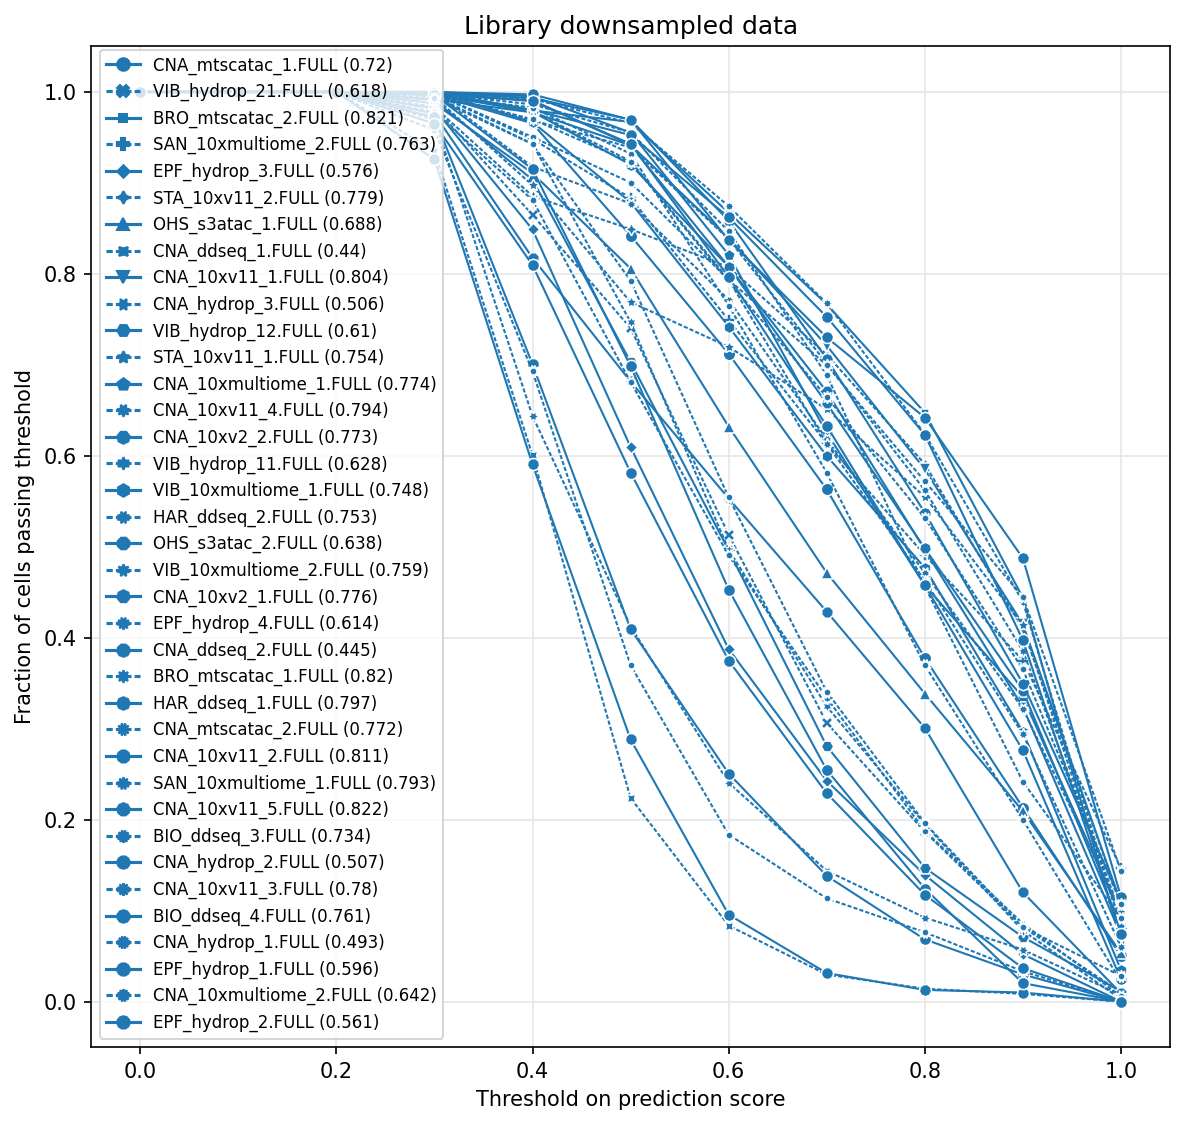

In [32]:
fig, ax = plt.subplots(1,1, figsize=(8,8), dpi=150 )
plot_frac_cells_passing_threshold(tp, ax, title="Library downsampled data", palette=color_dict_thr)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout()
# reorderLegend(ax, order_thr)
tp['Dataset'] = "Library downsampled data"
# plt_pred['Libds'] = tp.copy()
# plt.savefig(f'plts_pub/libds_label_transfer.png', transparent=False, bbox_inches='tight', facecolor='white', dpi=300)
# plt.savefig(f'plts_pub/libds_label_transfer.svg', transparent=False, bbox_inches='tight', facecolor='white', dpi=300)

### Cell type distributions

In [54]:
def calc_cell_type_dist(ct_pred, order):
    tp = pd.concat([ ct_pred[key] for key in order])
    tp_counts = tp[['sample_id','cell_type']].groupby(['sample_id','cell_type']).size().rename('counts')
    tp = tp_counts.groupby(level=0).apply(lambda x: x / x.sum() ).reset_index(name='fraction')
    return tp   

dict_keys(['Libds'])

In [61]:
tp = calc_cell_type_dist(ct_pred, ct_pred.keys())

In [62]:
tp['sample_id'].unique()

array(['BIO_ddseq_3.FULL', 'BIO_ddseq_4.FULL', 'BRO_mtscatac_1.FULL',
       'BRO_mtscatac_2.FULL', 'CNA_10xmultiome_1.FULL',
       'CNA_10xmultiome_2.FULL', 'CNA_10xv11_1.FULL', 'CNA_10xv11_2.FULL',
       'CNA_10xv11_3.FULL', 'CNA_10xv11_4.FULL', 'CNA_10xv11_5.FULL',
       'CNA_10xv2_1.FULL', 'CNA_10xv2_2.FULL', 'CNA_ddseq_1.FULL',
       'CNA_ddseq_2.FULL', 'CNA_hydrop_1.FULL', 'CNA_hydrop_2.FULL',
       'CNA_hydrop_3.FULL', 'CNA_mtscatac_1.FULL', 'CNA_mtscatac_2.FULL',
       'EPF_hydrop_1.FULL', 'EPF_hydrop_2.FULL', 'EPF_hydrop_3.FULL',
       'EPF_hydrop_4.FULL', 'HAR_ddseq_1.FULL', 'HAR_ddseq_2.FULL',
       'OHS_s3atac_1.FULL', 'OHS_s3atac_2.FULL', 'SAN_10xmultiome_1.FULL',
       'SAN_10xmultiome_2.FULL', 'STA_10xv11_1.FULL', 'STA_10xv11_2.FULL',
       'VIB_10xmultiome_1.FULL', 'VIB_10xmultiome_2.FULL',
       'VIB_10xv1_1.FULL', 'VIB_10xv2_1.FULL', 'VIB_10xv2_2.FULL',
       'VIB_hydrop_11.FULL', 'VIB_hydrop_12.FULL', 'VIB_hydrop_21.FULL',
       'VIB_hydrop_22.FULL'], dt

tp['name'] = [alias_dict[x] for x in tp['sample_id']]

In [63]:
tp['name'] = tp['sample_id']

In [64]:
def plot_cell_type_dist(tp, ax, title="", leg_size=7, leg_on=True, palette='tab20', order=None):
    g = sns.barplot(data=tp,
        x="cell_type", y="fraction", hue="name", hue_order=order,
        palette=palette, alpha=1,# height=6,
        ax=ax
    )
    ax.set_xlabel('')
    ax.set_ylabel('Fraction of cells')
    g.set_xticklabels(g.get_xticklabels(), rotation=15, ha='right', fontsize=8)
    #plt.legend(bbox_to_anchor=(1.025, 1), loc=2, borderaxespad=0., fontsize=8)
    ax.grid(color='0.9', axis='y')
    ax.legend(loc=0, fontsize=leg_size)
    ax.set_title(title, fontsize=8)
    return g

In [66]:
tp

,sample_id,cell_type,fraction,name
0,BIO_ddseq_3.FULL,B cell,0.099929,BIO_ddseq_3.FULL
1,BIO_ddseq_3.FULL,CD14+ monocyte,0.260885,BIO_ddseq_3.FULL
2,BIO_ddseq_3.FULL,CD16+ monocyte,0.046395,BIO_ddseq_3.FULL
3,BIO_ddseq_3.FULL,CD4+ T cell,0.407209,BIO_ddseq_3.FULL
4,BIO_ddseq_3.FULL,Cytotoxic T cell,0.128837,BIO_ddseq_3.FULL
...,...,...,...,...
282,VIB_hydrop_22.FULL,CD16+ monocyte,0.014448,VIB_hydrop_22.FULL
283,VIB_hydrop_22.FULL,CD4+ T cell,0.302374,VIB_hydrop_22.FULL
284,VIB_hydrop_22.FULL,Cytotoxic T cell,0.184727,VIB_hydrop_22.FULL
285,VIB_hydrop_22.FULL,Dendritic cell,0.004128,VIB_hydrop_22.FULL


/tmp/ipykernel_3799171/4062228201.py:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


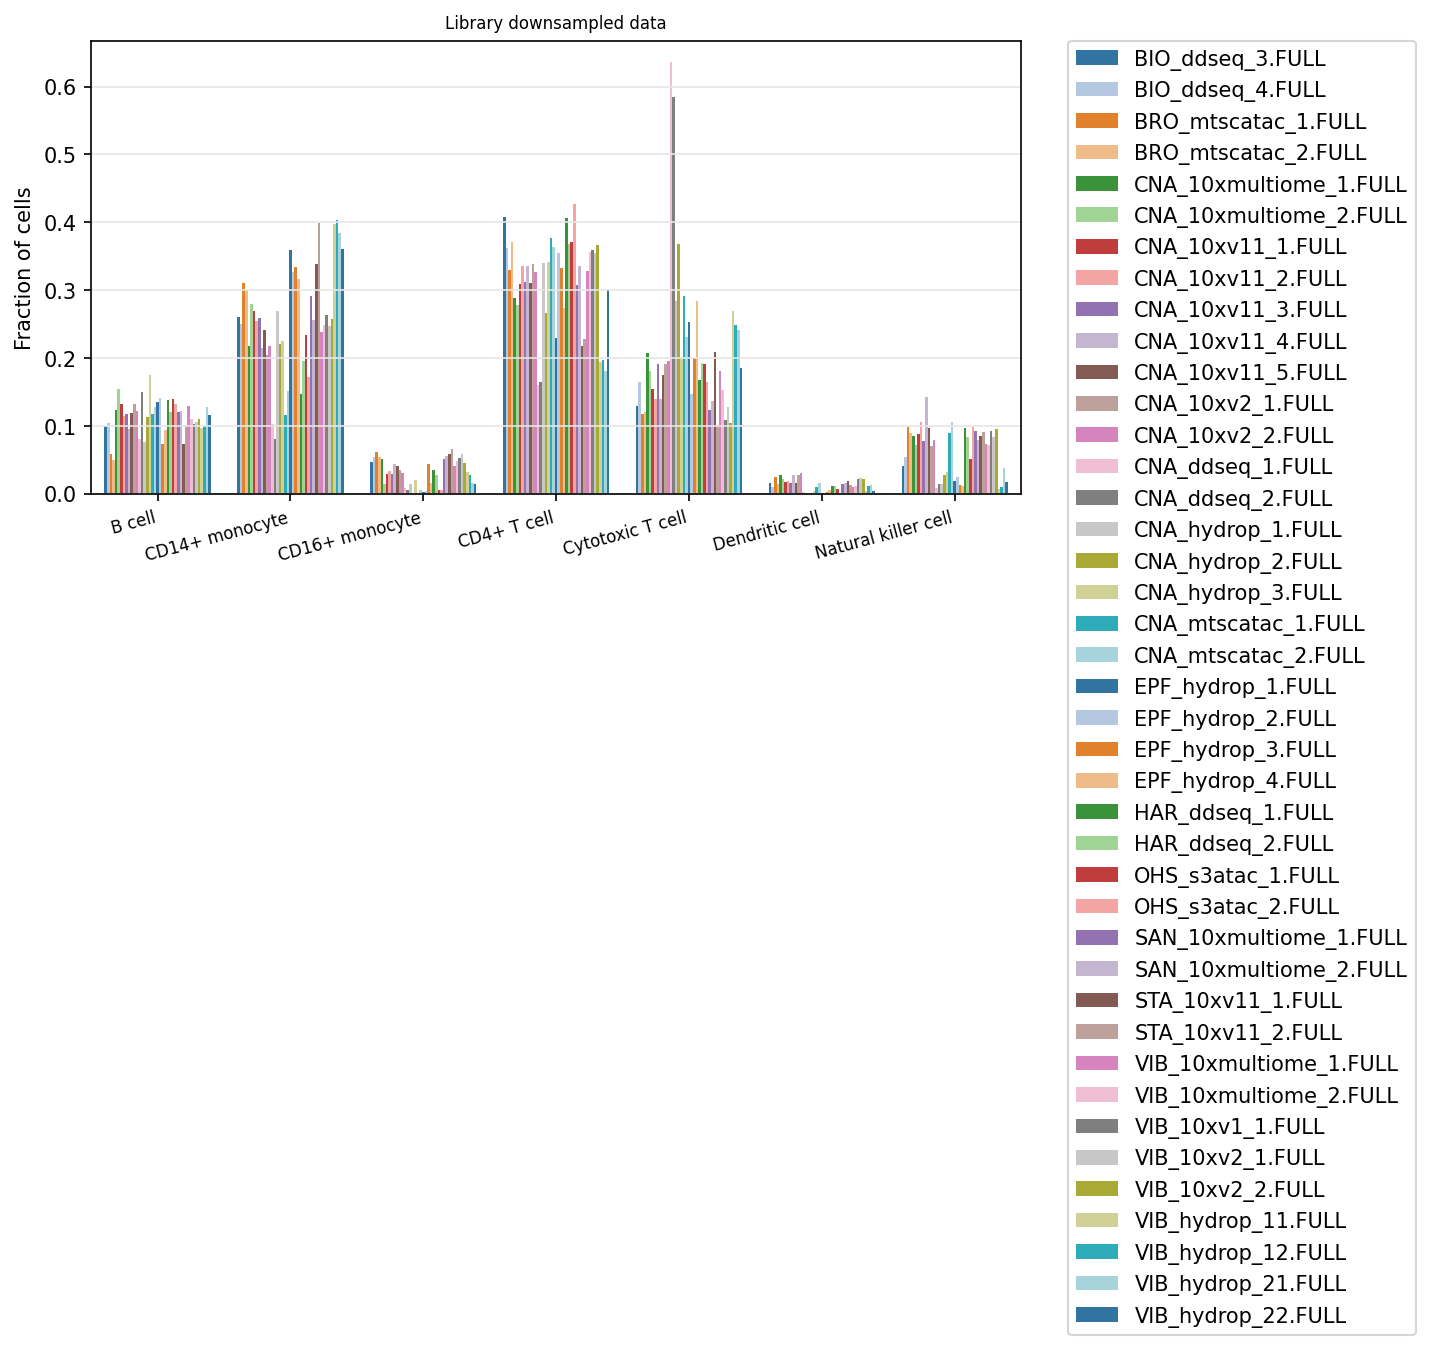

In [71]:
fig, ax = plt.subplots(1,1, figsize=(8,4), dpi=150 )
plot_cell_type_dist(tp, ax, title="Library downsampled data", order=sorted(ct_pred.keys()))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout()
# plt.savefig(f'plts_pub/libds_cell_distribution.png', transparent=False, bbox_inches='tight')
# plt.savefig(f'plts_pub/libds_cell_distribution.svg', transparent=False, bbox_inches='tight')